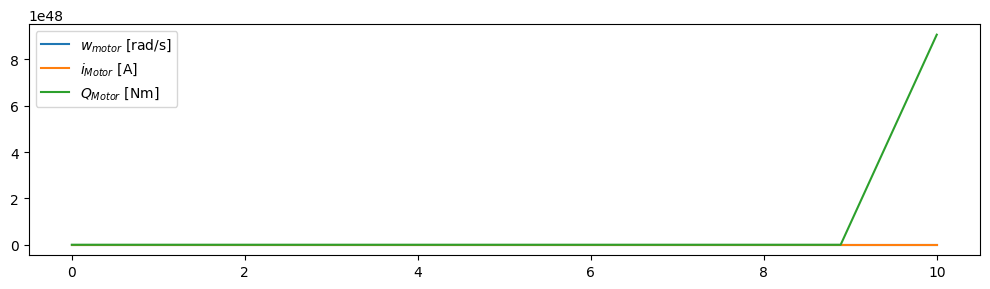

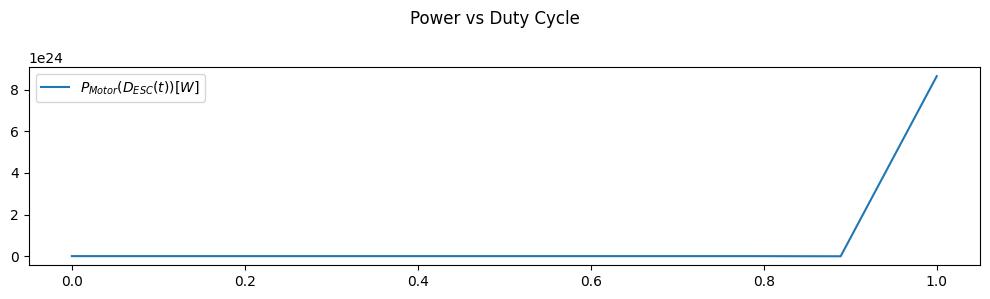

In [5]:
import numpy as np
from numpy import sqrt, pi
import matplotlib.pyplot as plt


def propulsion_states(t, x, y, u, params):
    # Parameters
    esc_eff = params['esc_eff']
    motor_K = params['motor_K']
    motor_R = params['motor_R']
    motor_J = params['motor_J']
    motor_B = params['motor_B']
    motor_L = params['motor_L']

    # States
    motor_w, motor_i = x

    # Inputs
    bat_V, esc_D = u

    # ESC-Motor model coupling
    motor_v = esc_eff * bat_V * esc_D

    # Outputs
    motor_load_Q = 0#y[0]

    # Motor states
    dwdt = -motor_B*motor_w/motor_J + motor_K*motor_i/motor_J - motor_load_Q/motor_J
    didt = -motor_K*motor_w/motor_L - motor_R*motor_i/motor_L + motor_v/motor_L

    return np.array([dwdt, didt])

def propulsion_outputs(t, x, y, u, params):
    # Parameters
    trans_eff = params['trans_eff']
    trans_K = params['trans_K']
    prop_eff = params['prop_eff']
    prop_D = params['prop_D']
    prop_kT = params['prop_kT']
    hull_S = params['hull_S']
    hull_C = params['hull_C']
    rho = params['rho']

    # States
    motor_w = x[0]

    # Motor-Transmission-Propeller-Hull coupling
    # motor_load_Q = prop_D**7*rho*prop_kT**2*(prop_D + sqrt((4.0*hull_S*hull_C + prop_D**2*pi)/pi))*motor_w**3/(hull_S*hull_C*trans_eff*trans_K**4*prop_eff)
    trans_wi = motor_w
    trans_wo = trans_wi * trans_K
    prop_w = trans_wo

    # Propeller torque equation
    prop_Q = prop_D**5 * rho * prop_kT * prop_w**2

    trans_Qo = prop_Q
    trans_Qi = trans_Qo * trans_K / trans_eff
    motor_load_Q = trans_Qi

    return motor_load_Q

def simulate(dt, t, x0, u, sys, params):
    func_outputs, func_states, num_outputs, num_states = sys

    # Initialize states
    x = np.zeros(shape=(len(t), num_states), dtype=np.float128)
    xdot = np.zeros_like(x)
    x[0] = x0
    y = np.zeros(shape=(len(t), num_outputs), dtype=np.float128)
    dt = np.diff(t)[0]

    # Perform simulation
    for k in range(1, len(t)):
        # Integrate states
        x[k] = dt * xdot[k-1] + x[k-1]

        # Compute states derivates
        xdot[k] = func_states(t=t, x=x[k], y=y[k], u=u[k], params=params)

        # Compute outputs
        y[k] = func_outputs(t=t, x=x[k], y=y[k], u=u[k], params=params)

    return (t, x, y, u)

# Parameters
params = {
    'trans_K': 13 / 22,
    'trans_eff': 0.95,
    'esc_eff': 0.8,
    'motor_eff': 0.8,
    'motor_K': 0.10390329,
    'motor_B': 0.01,
    'motor_J': 0.2,
    'motor_R': 0.03079777,
    'motor_L': 2.8e-05,
    'prop_D': 8.5 * 0.0254,
    'hull_S': 3.4,
    'hull_C': 1.0,
    'rho': 1025,
    'prop_eff': 0.6,
    'prop_kT': 1500,
}

# Initial state
x0 = np.array([0, 0])

# Time
dt = 0.0001
t_end = 10
t = np.linspace(0, t_end, t_end)

# Inputs
bat_V = np.ones_like(t) * 36
esc_D = np.linspace(0, 1, len(t))
u = np.array([bat_V, esc_D]).T

# Simulate
sys = (propulsion_outputs, propulsion_states, 1, 2)
_, res_x, res_y, _ = simulate(dt=dt, t=t, x0=x0, u=u, sys=sys, params=params)

# Plot
plt.figure(figsize=(10,3))
plt.plot(t, res_x[:,0], label='$w_{motor}$ [rad/s]')
plt.plot(t, res_x[:,1], label='$i_{Motor}$ [A]')
plt.plot(t, res_y[:,0], label='$Q_{Motor}$ [Nm]')
plt.legend(loc=2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(esc_D, bat_V*res_x[:,0], label='$P_{Motor}(D_{ESC}(t)) [W]$')
plt.legend(loc=2)
plt.suptitle('Power vs Duty Cycle')
plt.tight_layout()
plt.show()

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone

tzinfo = timezone("America/Sao_Paulo")

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = pd.read_csv("../../../models/2020/boat_data_1s.csv")
# df = pd.read_csv("../../../models/2020/boat_data_100ms.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
print(df.columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    ["bat_v", "bat_i", "esc_dt", "esc_ii", "esc_pi", "motor_rpm"],
]
df = df.interpolate(method="time")

rpm_to_radps = (2 * np.pi) / 60
df["motor_wo"] = df["motor_rpm"] * rpm_to_radps

# df.plot(subplots=True, figsize=(20, 8))
# plt.show()

# plt.plot()
# plt.scatter(df['esc_dt'], df['esc_pi'], s=0.2)


Index(['Unnamed: 0', 'bat_i', 'bat_ii', 'bat_io', 'bat_pi', 'bat_po', 'bat_p',
       'bat_v', 'bat1_v', 'bat2_v', 'bat3_v', 'boat_on', 'dms_on', 'esc_dt',
       'esc_ii', 'esc_pi', 'esc_po', 'esc_vi', 'esc_vo', 'mcb_po', 'mcb1_dt',
       'mcb1_io', 'mcb1_po', 'mcb1_vi', 'mcb1_vo', 'mcb2_dt', 'mcb2_io',
       'mcb2_po', 'mcb2_vi', 'mcb2_vo', 'motor_ii', 'motor_on', 'motor_pi',
       'motor_po', 'motor_rpm', 'motor_torq', 'motor_vi', 'mppt_io', 'mppt_pi',
       'mppt_po', 'mppt_vo', 'mppt1_dt', 'mppt1_ii', 'mppt1_pi', 'mppt1_vi',
       'mppt1_vo', 'mppt2_dt', 'mppt2_ii', 'mppt2_pi', 'mppt2_vi', 'mppt2_vo',
       'mppt3_dt', 'mppt3_ii', 'mppt3_pi', 'mppt3_vi', 'mppt3_vo', 'mppt4_dt',
       'mppt4_ii', 'mppt4_pi', 'mppt4_vi', 'mppt4_vo', 'prop_pi', 'prop_rpm',
       'prop_torq', 'solcast_AirTemp', 'solcast_energy', 'solcast_poa',
       'trans_pi', 'trans_po', 'trans_rpmi', 'trans_rpmo', 'trans_torqi',
       'trans_torqo'],
      dtype='object')


In [77]:
import lmfit

def resid(params, x, ydata):
    dt = params['dt']
    t, D, Vbat = x
    sys = (propulsion_outputs, propulsion_states, 1, 2)
    ymodel = simulate(dt=dt, t=t, x0=np.array([0,0]), u=np.array([bat_V, esc_D]).T, sys=sys, params=params.valuesdict())[2]

    return np.array([ymodel - ydata]).flatten()


params = lmfit.Parameters()
params.add_many(
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ('trans_K', 13 / 22, False, 0.1, 2, None, None),
    ('trans_eff', 0.95, False, 0.5, 1, None, None),
    ('esc_eff', 0.8, False, 0.5, 1, None, None),
    ('motor_K', 0.10390329, False, 0.1, 0.15, None, None),
    ('motor_B', 0.01, True, 1e-3, 1, None, None),
    ('motor_J', 0.2, False, 1e-3, 1, None, None),
    ('motor_R', 0.03079777, False, 1e-3, 1, None, None),
    ('motor_L', 2.8, False, 1e-6, 1e-3, None, None),
    ('prop_D', 8.5 * 0.0254, False, 0.1, 0.5, None, None),
    ('hull_S', 3.4, False, 1, 10, None, None),
    ('hull_C', 1.0, False, 1e-3, 1e3, None, None),
    ('rho', 1025, False, 1000, 1040, None, None),
    ('prop_eff', 0.6, False, 0.2, 0.8, None, None),
    ('prop_kT', 0.001, True, 1e-6, 1e6, None, None),
    ('dt', 0.001, False, 0.0001, 0.01, None, None),
)

T = (df.index - df.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
dt = 0.001
Vbat = df["bat_v"].to_numpy()
D = df["esc_dt"].to_numpy()
data = df[["motor_wo", "esc_ii"]].copy(deep=True)

data = data.to_numpy()

result = lmfit.minimize(
    resid,
    params,
    args=([T, D, Vbat], data),
    method="least_squares"
)

result

IndexError: index 10 is out of bounds for axis 0 with size 10

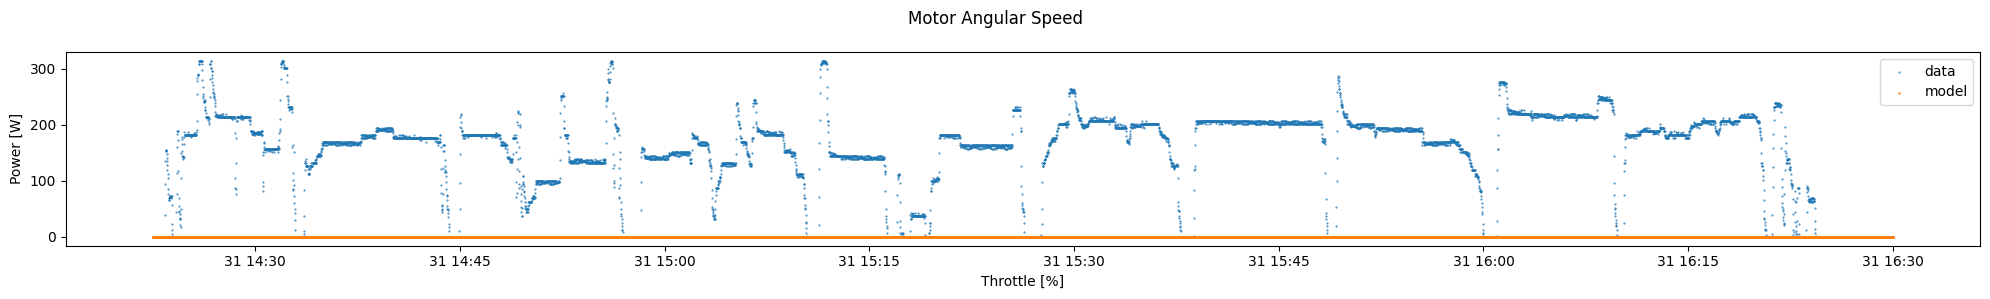

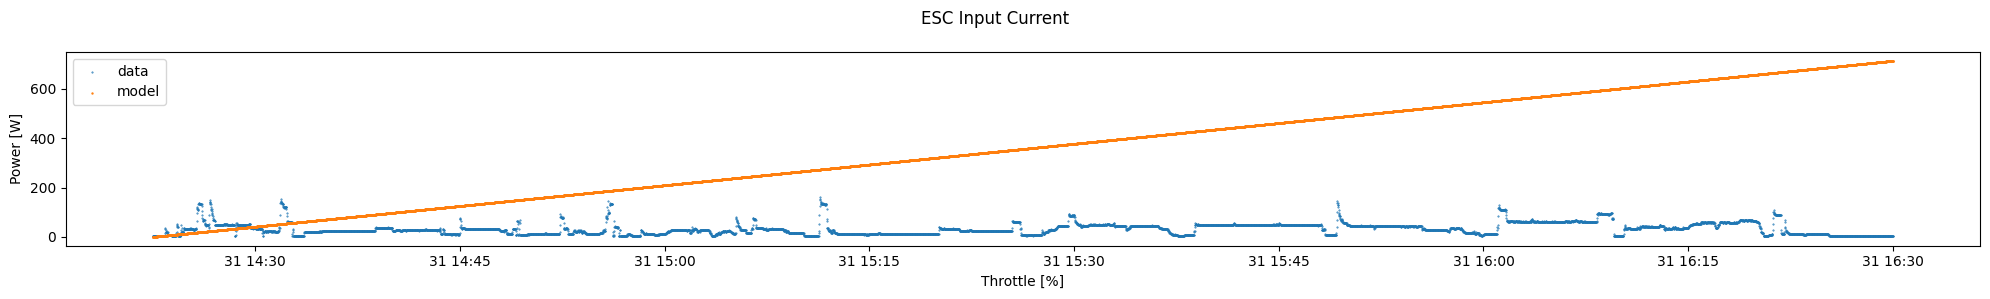

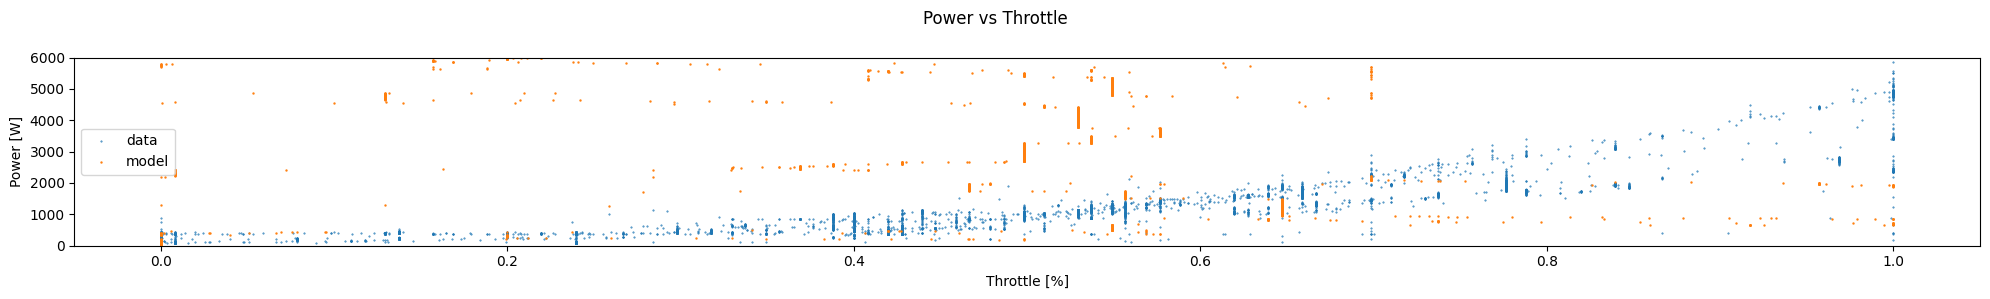

[]

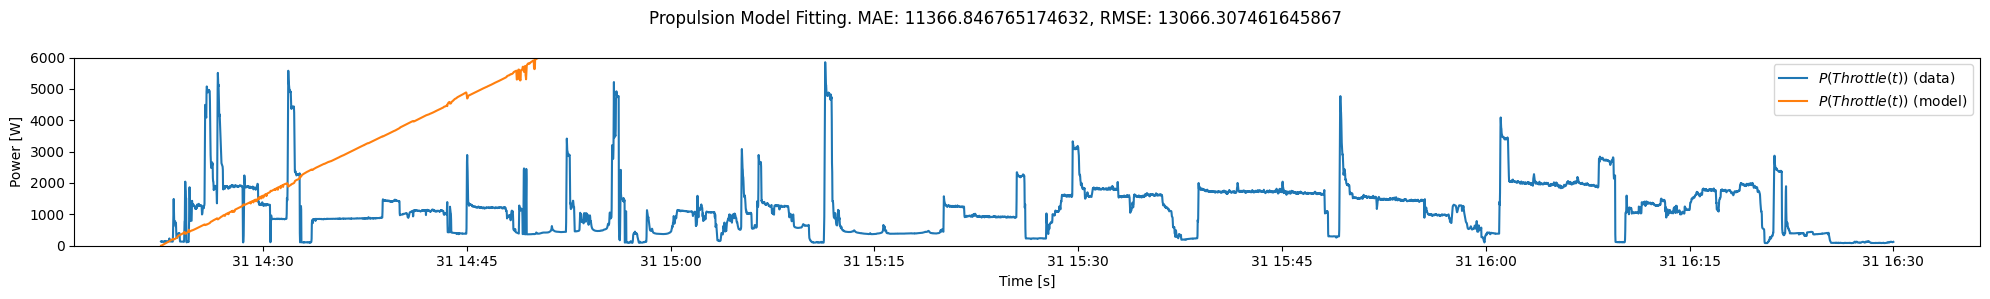

In [ ]:
sys = (propulsion_outputs, propulsion_states, 1, 2)
_, res_x, _, _ = simulate(dt=0.001, t=T, x0=x0, u=u, sys=sys, params=result.params.valuesdict())
df_model = pd.DataFrame(res_x, columns=("motor_wo", "esc_ii"))

df_model['esc_pi'] = df_model['esc_ii'].to_numpy() * df['bat_v'].to_numpy()

rmse = (((df['esc_pi'].to_numpy() - df_model['esc_pi'].to_numpy())**2).sum() / len(df))**(1/2)
mae = abs(df['esc_pi'].to_numpy() - df_model['esc_pi'].to_numpy()).sum() / len(df)

plt.figure(figsize=(20,3))
plt.scatter(df.index, df['motor_wo'], label='data', s=0.2)
plt.scatter(df.index, df_model['motor_wo'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Motor Angular Speed')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,3))
plt.scatter(df.index, df['esc_ii'], label='data', s=0.2)
plt.scatter(df.index, df_model['esc_ii'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('ESC Input Current')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,3))
plt.scatter(df['esc_dt'], df['esc_pi'], label='data', s=0.2)
plt.scatter(df['esc_dt'], df_model['esc_pi'], label='model', s=0.5)
plt.xlabel('Throttle [%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
plt.suptitle('Power vs Throttle')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 3))
plt.plot(df.index, df['esc_pi'], label='$P(Throttle(t))$ (data)')
plt.plot(df.index, df_model['esc_pi'], label='$P(Throttle(t))$ (model)')
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.ylim([0,6000])
plt.tight_layout()
plt.plot()